Commit: [0edba49611125b58f5460ac362df2f5dc2e02e44 (message: "Revert to 6th of january")](https://github.com/squillero/computational-intelligence/tree/0edba49611125b58f5460ac362df2f5dc2e02e44)

In [ ]:
from tqdm.auto import tqdm
from abc import ABC, abstractmethod
from copy import deepcopy
from enum import Enum
import numpy as np
import random
import time
import matplotlib.pyplot as plt

In [ ]:
EPISODES = 30
BOARD_SIZE = 5

## Game class definition
It contains *Move* class, *Player* class as interface for our players and ***Game*** class implemented by Andrea Calabrese.

In [ ]:
class Move(Enum):
    """
    Selects where you want to place the taken piece. The rest of the pieces are shifted
    """

    TOP = 0
    BOTTOM = 1
    LEFT = 2
    RIGHT = 3


class Player(ABC):
    def __init__(self) -> None:
        """You can change this for your player if you need to handle state/have memory"""
        pass

    @abstractmethod
    def make_move(self, game: "Game") -> tuple[tuple[int, int], Move]:
        """
        The game accepts coordinates of the type (X, Y). X goes from left to right, while Y goes from top to bottom, as in 2D graphics.
        Thus, the coordinates that this method returns shall be in the (X, Y) format.

        game: the Quixo game. You can use it to override the current game with yours, but everything is evaluated by the main game
        return values: this method shall return a tuple of X,Y positions and a move among TOP, BOTTOM, LEFT and RIGHT
        """
        pass


class Game(object):
    def __init__(self) -> None:
        self._board = np.ones((5, 5), dtype=np.uint8) * -1
        self.current_player_idx = 1

    def get_board(self) -> np.ndarray:
        '''
        Returns the board
        '''
        return deepcopy(self._board)

    def get_current_player(self) -> int:
        '''
        Returns the current player
        '''
        return deepcopy(self.current_player_idx)

    def print(self):
        '''Prints the board. -1 are neutral pieces, 0 are pieces of player 0, 1 pieces of player 1'''
        print(self._board)

    def check_winner(self) -> int:
        '''Check the winner. Returns the player ID of the winner if any, otherwise returns -1'''
        # for each row
        for x in range(self._board.shape[0]):
            # if a player has completed an entire row
            if self._board[x, 0] != -1 and all(self._board[x, :] == self._board[x, 0]):
                # return the relative id
                return self._board[x, 0]
        # for each column
        for y in range(self._board.shape[1]):
            # if a player has completed an entire column
            if self._board[0, y] != -1 and all(self._board[:, y] == self._board[0, y]):
                # return the relative id
                return self._board[0, y]
        # if a player has completed the principal diagonal
        if self._board[0, 0] != -1 and all(
            [self._board[x, x]
                for x in range(self._board.shape[0])] == self._board[0, 0]
        ):
            # return the relative id
            return self._board[0, 0]
        # if a player has completed the secondary diagonal
        if self._board[0, -1] != -1 and all(
            [self._board[x, -(x + 1)]
             for x in range(self._board.shape[0])] == self._board[0, -1]
        ):
            # return the relative id
            return self._board[0, -1]
        return -1

    def play(self, player1: Player, player2: Player) -> int:
        '''Play the game. Returns the winning player'''
        players = [player1, player2]
        winner = -1
        while winner < 0:
            self.current_player_idx += 1
            self.current_player_idx %= len(players)
            ok = False
            while not ok:
                from_pos, slide = players[self.current_player_idx].make_move(
                    self)
                ok = self.__move(from_pos, slide, self.current_player_idx)

            # prints made by us, to delete before submitting the project

            print("PLAYER", self.current_player_idx, "MOVED", from_pos, slide)
            #self.print_move(from_pos, slide)    # board print
            self.print()
            print()

            #

            winner = self.check_winner()
        return winner

    def __move(self, from_pos: tuple[int, int], slide: Move, player_id: int) -> bool:
        '''Perform a move'''
        if player_id > 2:
            return False
        # Oh God, Numpy arrays
        prev_value = deepcopy(self._board[(from_pos[1], from_pos[0])])
        acceptable = self.__take((from_pos[1], from_pos[0]), player_id)
        if acceptable:
            acceptable = self.__slide((from_pos[1], from_pos[0]), slide)
            if not acceptable:
                self._board[(from_pos[1], from_pos[0])] = deepcopy(prev_value)
        return acceptable

    def __take(self, from_pos: tuple[int, int], player_id: int) -> bool:
        '''Take piece'''
        # acceptable only if in border
        acceptable: bool = (
            # check if it is in the first row
            (from_pos[0] == 0 and from_pos[1] < 5)
            # check if it is in the last row
            or (from_pos[0] == 4 and from_pos[1] < 5)
            # check if it is in the first column
            or (from_pos[1] == 0 and from_pos[0] < 5)
            # check if it is in the last column
            or (from_pos[1] == 4 and from_pos[0] < 5)
            # and check if the piece can be moved by the current player
        ) and (self._board[from_pos] < 0 or self._board[from_pos] == player_id)
        if acceptable:
            self._board[from_pos] = player_id
        return acceptable

    def __slide(self, from_pos: tuple[int, int], slide: Move) -> bool:
        '''Slide the other pieces'''
        # define the corners
        SIDES = [(0, 0), (0, 4), (4, 0), (4, 4)]
        # if the piece position is not in a corner
        if from_pos not in SIDES:
            # if it is at the TOP, it can be moved down, left or right
            acceptable_top: bool = from_pos[0] == 0 and (
                slide == Move.BOTTOM or slide == Move.LEFT or slide == Move.RIGHT
            )
            # if it is at the BOTTOM, it can be moved up, left or right
            acceptable_bottom: bool = from_pos[0] == 4 and (
                slide == Move.TOP or slide == Move.LEFT or slide == Move.RIGHT
            )
            # if it is on the LEFT, it can be moved up, down or right
            acceptable_left: bool = from_pos[1] == 0 and (
                slide == Move.BOTTOM or slide == Move.TOP or slide == Move.RIGHT
            )
            # if it is on the RIGHT, it can be moved up, down or left
            acceptable_right: bool = from_pos[1] == 4 and (
                slide == Move.BOTTOM or slide == Move.TOP or slide == Move.LEFT
            )
        # if the piece position is in a corner
        else:
            # if it is in the upper left corner, it can be moved to the right and down
            acceptable_top: bool = from_pos == (0, 0) and (
                slide == Move.BOTTOM or slide == Move.RIGHT)
            # if it is in the lower left corner, it can be moved to the right and up
            acceptable_left: bool = from_pos == (4, 0) and (
                slide == Move.TOP or slide == Move.RIGHT)
            # if it is in the upper right corner, it can be moved to the left and down
            acceptable_right: bool = from_pos == (0, 4) and (
                slide == Move.BOTTOM or slide == Move.LEFT)
            # if it is in the lower right corner, it can be moved to the left and up
            acceptable_bottom: bool = from_pos == (4, 4) and (
                slide == Move.TOP or slide == Move.LEFT)
        # check if the move is acceptable
        acceptable: bool = acceptable_top or acceptable_bottom or acceptable_left or acceptable_right
        # if it is
        if acceptable:
            # take the piece
            piece = self._board[from_pos]
            # if the player wants to slide it to the left
            if slide == Move.LEFT:
                # for each column starting from the column of the piece and moving to the left
                for i in range(from_pos[1], 0, -1):
                    # copy the value contained in the same row and the previous column
                    self._board[(from_pos[0], i)] = self._board[(
                        from_pos[0], i - 1)]
                # move the piece to the left
                self._board[(from_pos[0], 0)] = piece
            # if the player wants to slide it to the right
            elif slide == Move.RIGHT:
                # for each column starting from the column of the piece and moving to the right
                for i in range(from_pos[1], self._board.shape[1] - 1, 1):
                    # copy the value contained in the same row and the following column
                    self._board[(from_pos[0], i)] = self._board[(
                        from_pos[0], i + 1)]
                # move the piece to the right
                self._board[(from_pos[0], self._board.shape[1] - 1)] = piece
            # if the player wants to slide it upward
            elif slide == Move.TOP:
                # for each row starting from the row of the piece and going upward
                for i in range(from_pos[0], 0, -1):
                    # copy the value contained in the same column and the previous row
                    self._board[(i, from_pos[1])] = self._board[(
                        i - 1, from_pos[1])]
                # move the piece up
                self._board[(0, from_pos[1])] = piece
            # if the player wants to slide it downward
            elif slide == Move.BOTTOM:
                # for each row starting from the row of the piece and going downward
                for i in range(from_pos[0], self._board.shape[0] - 1, 1):
                    # copy the value contained in the same column and the following row
                    self._board[(i, from_pos[1])] = self._board[(
                        i + 1, from_pos[1])]
                # move the piece down
                self._board[(self._board.shape[0] - 1, from_pos[1])] = piece
        return acceptable

## MyGame definition
***MyGame*** class is a subclass of *Game*: it inherits its methods and attributes and it contains also new useful methods.

In [ ]:
class MyGame(Game):
    """
    This class is used throughout the project instead of the Game class, as discussed with the professor, to adapt it to our needs.
    In this class we:
        - Override the __hash__ and __eq__ method to make the Game object hashable, and therefore usable as key in a dictionary;
        - Implement the is_valid method, which is used to check if a move is valid without modifying the current game, by applying the move function on a copy of the game;
        - Expose the move method to use it in a cleaner way throughout the project.
    """

    def __init__(self) -> None:
        super().__init__()


    def longest_sequence(self, player_id: int) -> int:
        #Returns the length of the longest sequence of pieces of the same player

        board = self.get_board()
        max_sequence = 0
        for i in range(board.shape[0]):
            for j in range(board.shape[1]):
                if board[i][j] == player_id:
                    # check horizontal sequence
                    sequence = 0
                    for k in range(j, board.shape[1]):
                        if board[i][k] == player_id:
                            sequence += 1
                        else:
                           break
                    max_sequence = max(max_sequence, sequence)

                    # check vertical sequence
                    sequence = 0
                    for k in range(i, board.shape[0]):
                        if board[k][j] == player_id:
                            sequence += 1
                        else:
                            break
                    max_sequence = max(max_sequence, sequence)

                    # check diagonal sequence
                    sequence = 0
                    for k in range(i, board.shape[0]):
                        if j + k - i < board.shape[1]:
                            if board[k][j + k - i] == player_id:
                                sequence += 1
                            else:
                                break
                    max_sequence = max(max_sequence, sequence)

                    # check anti-diagonal sequence
                    sequence = 0
                    for k in range(i, board.shape[0]):
                        if j - k + i >= 0:
                            if board[k][j - k + i] == player_id:
                                sequence += 1
                            else:
                                break
                    max_sequence = max(max_sequence, sequence)
        return max_sequence


    def print(self):
        board = [["" for _ in range(BOARD_SIZE)] for _ in range(BOARD_SIZE)]
        for x in range(self._board.shape[0]):
            for y in range(self._board.shape[1]):
                if self._board[x][y] == -1:
                    board[x][y] = "-"
                elif self._board[x][y] == 0:
                    board[x][y] = "O"
                else:
                    board[x][y] = "X"
        for x in board:
            print(x)

    def is_valid(self, from_pos: tuple[int, int], slide: Move, player_id: int) -> bool:
        cp = deepcopy(self)
        return cp._Game__move(from_pos, slide, player_id)

    def move(self, from_pos: tuple[int, int], slide: Move, player_id: int) -> bool:
        return self._Game__move(from_pos, slide, player_id)

## Player definition

In [ ]:
class RandomPlayer(Player):
    def __init__(self) -> None:
        super().__init__()

    def make_move(self, game: "MyGame") -> tuple[tuple[int, int], Move]:
        from_pos = (random.randint(0, 4), random.randint(0, 4))
        move = random.choice([Move.TOP, Move.BOTTOM, Move.LEFT, Move.RIGHT])
        return from_pos, move


class AlphaBetaPlayer(Player):
    def __init__(self, depth) -> None:
        super().__init__()
        self.depth = depth

    def get_possible_moves(self, game: "MyGame") -> list[tuple[tuple[int, int], Move]]:
        possible_moves = []
        for x in range(BOARD_SIZE):
            for y in range(BOARD_SIZE):
                if x>=1 and x<BOARD_SIZE-1 and y>=1 and y<BOARD_SIZE-1: # to skip internal cubes
                    continue
                for move in [Move.TOP, Move.BOTTOM, Move.LEFT, Move.RIGHT]:
                    if game.is_valid((x, y), move, game.current_player_idx):
                        possible_moves.append(((x, y), move))
        return possible_moves

    def best_move(self, game: "MyGame") -> tuple[tuple[int, int], Move]:
        best_score = float("-inf")
        best_m = None

        for move in self.get_possible_moves(game):
            new_game = deepcopy(game)
            new_game.move(move[0], move[1], new_game.current_player_idx)
            score = self.minimax(new_game, 0, float("-inf"), float("inf"), False)
            if score > best_score:
                best_score = score
                best_m = move

        return best_m[0], best_m[1]

    def minimax(self, game: "MyGame", depth, alpha, beta, is_maximizing):
        if game.check_winner() != -1 or depth >= self.depth:
            return self.evaluate(game)

        if is_maximizing:
            best_score = float("-inf")
            for move in self.get_possible_moves(game):
                new_game = deepcopy(game)

                #
                player = new_game.current_player_idx + 1
                player %= 2
                #

                new_game.move(move[0], move[1], new_game.current_player_idx)
                score = self.minimax(new_game, depth + 1, alpha, beta, False)
                best_score = max(score, best_score)
                alpha = max(alpha, score)
                if beta <= alpha:
                    break

            return best_score
        else:
            best_score = float("inf")
            for move in self.get_possible_moves(game):
                new_game = deepcopy(game)

                #
                player = new_game.current_player_idx + 1
                player %= 2
                #

                new_game.move(move[0], move[1], new_game.current_player_idx)
                score = self.minimax(new_game, depth + 1, alpha, beta, True)
                best_score = min(score, best_score)
                beta = min(beta, score)
                if beta <= alpha:
                    break
            return best_score

    def evaluate(self, game: "MyGame") -> int:
        winner = game.check_winner()
        if winner == game.current_player_idx:
            return 1
        elif winner == 1 - game.current_player_idx:
            return -1
        else:
            return (game.longest_sequence(game.current_player_idx) - 2.5) / 5

    def make_move(self, game: "MyGame") -> tuple[tuple[int, int], Move]:
        start_time = time.time()
        from_pos, move = self.best_move(game)
        end_time = time.time()
        elapsed_time = end_time - start_time
        print(
            "Alpha Beta Pruning move takes time: ",
            elapsed_time,
            " with depth: ",
            self.depth,
        )
        return from_pos, move

## Draw_pie_chart


In [ ]:
def draw_pie_chart(win_rate, loss_rate, draw_rate, title):
    # Define data
    data = [win_rate, loss_rate, draw_rate]
    labels = ["Wins", "Losses", "Draws"]
    colors = ["#29F05F", "#EC3954", "#4570F8"]

    # Create a pie chart
    fig, ax = plt.subplots()
    ax.pie(data, labels=labels, colors=colors, autopct="%1.1f%%")
    ax.set_title(title)

    # Show the chart
    plt.show()

## Gameplay

  0%|          | 0/30 [00:00<?, ?it/s]

['-', '-', '-', '-', '-']
['-', '-', '-', '-', '-']
['-', '-', '-', '-', '-']
['-', '-', '-', '-', '-']
['-', '-', '-', '-', '-']

Alpha Beta Pruning move takes time:  5.160510063171387  with depth:  2
PLAYER 0 MOVED (0, 0) Move.BOTTOM
['-', '-', '-', '-', '-']
['-', '-', '-', '-', '-']
['-', '-', '-', '-', '-']
['-', '-', '-', '-', '-']
['O', '-', '-', '-', '-']

PLAYER 1 MOVED (4, 2) Move.BOTTOM
['-', '-', '-', '-', '-']
['-', '-', '-', '-', '-']
['-', '-', '-', '-', '-']
['-', '-', '-', '-', '-']
['O', '-', '-', '-', 'X']

Alpha Beta Pruning move takes time:  5.553945779800415  with depth:  2
PLAYER 0 MOVED (0, 0) Move.BOTTOM
['-', '-', '-', '-', '-']
['-', '-', '-', '-', '-']
['-', '-', '-', '-', '-']
['O', '-', '-', '-', '-']
['O', '-', '-', '-', 'X']

PLAYER 1 MOVED (1, 0) Move.LEFT
['X', '-', '-', '-', '-']
['-', '-', '-', '-', '-']
['-', '-', '-', '-', '-']
['O', '-', '-', '-', '-']
['O', '-', '-', '-', 'X']

Alpha Beta Pruning move takes time:  4.954107761383057  with depth:  

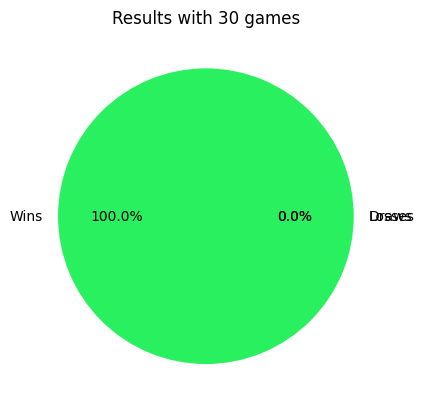

In [ ]:
counter1 = 0
counter2 = 0
start_time = time.time()
for _ in tqdm(range(EPISODES)):
    g = MyGame()
    g.print()
    print()


    player1 = AlphaBetaPlayer(2)  # Plays with O <-> 0
    player2 = RandomPlayer()  # Plays with X <-> 1
    winner = g.play(player1, player2)
    if winner == 0:
        counter1 += 1
    if winner == 1:
        counter2 += 1
    g.print()
    print(f"Winner: Player {winner}")

end_time = time.time()
elapsed_time = end_time - start_time

print("Win: ", counter1, "/", EPISODES)
print("Losses ", counter2, "/", EPISODES)
print("Ties: ", EPISODES - counter1 - counter2, "/", EPISODES)
print("Time for: ", EPISODES, "--> ", elapsed_time)
draw_pie_chart(
    counter1,
    counter2,
    EPISODES - counter1 - counter2,
    f"Results with {EPISODES} games",
)

## RESULTS
| EPISODES | DEPTH | REWARDS | WINS |
|----------|-------|---------|-------|
| 30 | 1 | win 1, lose -1, intermediate_node [-0.5,0.5]  | 80% around |
| 30 | 2 | win 1, lose -1, intermediate_node [-0.5,0.5]  | 100% around |
| 30 | 3 | win 1, lose -1, intermediate_node [-0.5,0.5]  | 73% around |
| 30 | 4 | win 1, lose -1, intermediate_node [-0.5,0.5]  | 93% |